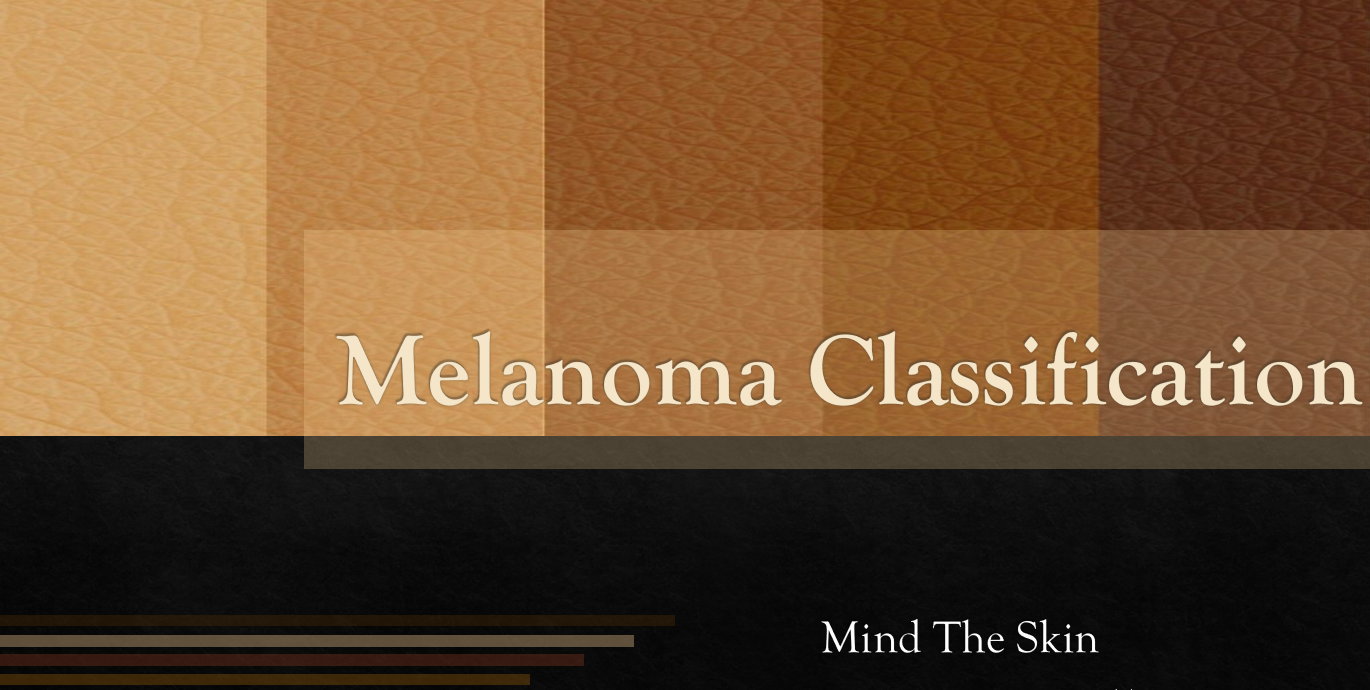

### Import Libraries


In [2]:
import numpy as np
import pandas as pd
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import tensorflow as tf
from functools import partial
#import efficientnet.tfkeras as efn
from sklearn.model_selection import train_test_split
import cv2
from skimage import io
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler

#### set up directories

In [3]:
Train_Directory = "C:/Users/Ioanna/Desktop/MLP/SkinCancerData/archive/Melanoma_Data/Train_Data"
Validation_Directory = "C:/Users/Ioanna/Desktop/MLP/SkinCancerData/archive/Melanoma_Data/Validation_Data"
Test_Directory = "C:/Users/Ioanna/Desktop/MLP/SkinCancerData/archive/Melanoma_Data/Test_Data"

In [4]:
from keras.preprocessing.image import ImageDataGenerator

* ImageDataGenerator for training dataset, will proceed with some data augmentation and rescaling of the images.

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest')

* For validation and test dataset, we will proceed only with rescaling of the data

In [6]:
test_datagen = ImageDataGenerator(rescale=1./255)

* Load train data

In [7]:
train_generator = train_datagen.flow_from_directory(
    Train_Directory,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 17224 images belonging to 8 classes.


* Load validation data

In [8]:
validation_generator = test_datagen.flow_from_directory(
    Validation_Directory,
    target_size=(150,150),
    batch_size=20,
    class_mode='categorical')

Found 4307 images belonging to 8 classes.


* Load test data

In [70]:
test_generator = test_datagen.flow_from_directory(
    Test_Directory,
    target_size=(150,150),
    batch_size=20,
    shuffle=False,
    class_mode='categorical')

Found 3800 images belonging to 8 classes.


## Build VGG pretrained model

In [13]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

#### Loading the base model

In [10]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (150, 150, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58892288/58889256 [==============================] - 67s 1us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False

Compile and Fit

In [17]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer  and ReLU activation
x = layers.Dense(128, activation='relu')(x)

# Add a dropout rate of 0.25
x = layers.Dropout(0.25)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'categorical_crossentropy',metrics = ['acc'])

We will now build the final model based on the training and validation sets we created earlier.

In [35]:
vgghist = model.fit(train_generator, validation_data = validation_generator, epochs = 50)

Epoch 1/50
862/862 [==============================] - 959s 1s/step - loss: 1.1412 - acc: 0.9121 - val_loss: 1.0769 - val_acc: 0.9169
Epoch 2/50
862/862 [==============================] - 948s 1s/step - loss: 1.1295 - acc: 0.9125 - val_loss: 1.0617 - val_acc: 0.9178
Epoch 3/50
862/862 [==============================] - 997s 1s/step - loss: 1.1171 - acc: 0.9133 - val_loss: 1.0573 - val_acc: 0.9182
Epoch 4/50
862/862 [==============================] - 1061s 1s/step - loss: 1.1055 - acc: 0.9142 - val_loss: 1.0431 - val_acc: 0.9189
Epoch 5/50
862/862 [==============================] - 1062s 1s/step - loss: 1.0973 - acc: 0.9148 - val_loss: 1.0440 - val_acc: 0.9184
Epoch 6/50
862/862 [==============================] - 1060s 1s/step - loss: 1.0971 - acc: 0.9146 - val_loss: 1.0354 - val_acc: 0.9188
Epoch 7/50
862/862 [==============================] - 1056s 1s/step - loss: 1.0915 - acc: 0.9153 - val_loss: 1.0322 - val_acc: 0.9202
Epoch 8/50
862/862 [==============================] - 986s 1s/ste

#### Model Prediction

In [36]:
model3 = model.predict(test_generator)

In [72]:
pred = model.predict(test_generator)

#### function for Accuracy and Loss

In [42]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

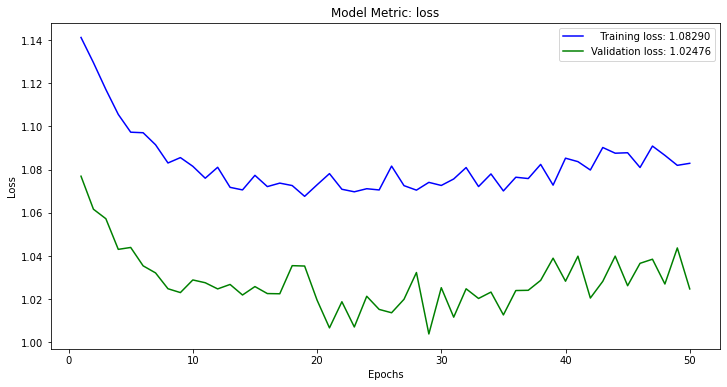

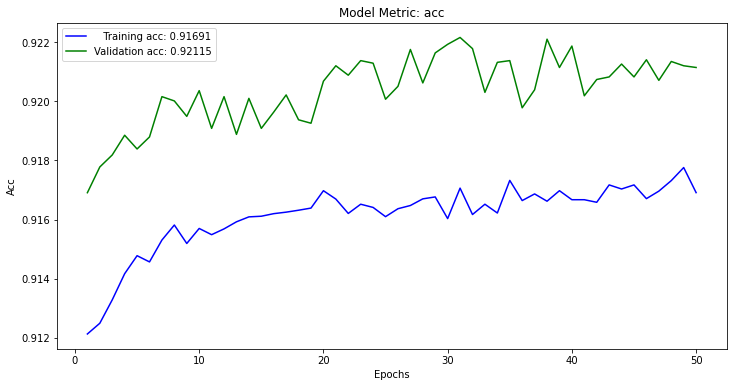

In [43]:
plot_keras_history(vgghist)

### model evaluation (validation data)

In [67]:
score_validation = model.evaluate(
   validation_generator,                  # labels
    batch_size=100,   # batch size
    verbose=1                # the most extended verbose
)


print('\nValidation categorical_crossentropy:', score[0])
print('\nValidation accuracy:', score[1])

216/216 [==============================] - 179s 829ms/step - loss: 1.0248 - acc: 0.9211

Validation categorical_crossentropy: 1.049519419670105

Validation accuracy: 0.9200657606124878


### model evaluation (test data)

In [83]:
score = model.evaluate(
   test_generator,                  # labels
    batch_size=100,   # batch size
    verbose=1                # the most extended verbose
)


print('\nTest categorical_crossentropy:', score[0])
print('\nTest accuracy:', score[1])

190/190 [==============================] - 161s 848ms/step - loss: 1.0495 - acc: 0.9201

Test categorical_crossentropy: 1.0495193004608154

Test accuracy: 0.9200657606124878


In [85]:
print('Test accuracy: {:.3f} %'.format(100 * score[1]))

Test accuracy: 92.007 %


#### Save weights

In [82]:
directory="C:/Users/Ioanna/Desktop/MLP/Model_Weight"
model.save_weights(directory + 'VGGmodel3_weights.h5')

##### Function for confusion matrix

In [75]:
from typing import List, Tuple

In [76]:
def print_confusion_matrix(y_true,
                           y_pred,
                           class_names: List[str],
                           figsize: Tuple[int, int] = (10, 7),
                           fontsize: int = 14) -> pd.DataFrame:
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heat-map.

    For something more extraordinary check this repo:
    https://github.com/wcipriano/pretty-print-confusion-matrix


    :param class_names:  An ordered list of class names
    :param figsize: A 2-long tuple, the first value determining the horizontal size of the outputted
                    figure, the second determining the vertical size. Defaults to (10,7).
    :param fontsize: Font size for axes labels. Defaults to 14.
    :return: The confusion matrix as a dataset
    """
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    fig = plt.figure(figsize=figsize)

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    except ValueError:

        raise ValueError("Confusion matrix values must be integers.")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                                 rotation=0,
                                 ha='right',
                                 fontsize=fontsize)

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                                 rotation=45,
                                 ha='right',
                                 fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    return df_cm

#### Classification report

In [77]:
y_pred_class = np.argmax(pred, axis=-1)
y_pred_class

array([4, 2, 0, ..., 5, 4, 1], dtype=int64)

In [78]:
test_generator.classes

array([0, 0, 0, ..., 7, 7, 7])

In [79]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, y_pred_class))

              precision    recall  f1-score   support

           0       0.39      0.13      0.20       130
           1       0.51      0.70      0.59       499
           2       0.38      0.27      0.32       394
           3       0.00      0.00      0.00        36
           4       0.59      0.43      0.49       678
           5       0.75      0.88      0.81      1931
           6       0.40      0.02      0.04        94
           7       0.70      0.18      0.29        38

    accuracy                           0.65      3800
   macro avg       0.46      0.33      0.34      3800
weighted avg       0.62      0.65      0.62      3800



C:\Users\Ioanna\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion matrix

In [80]:
import seaborn as sns

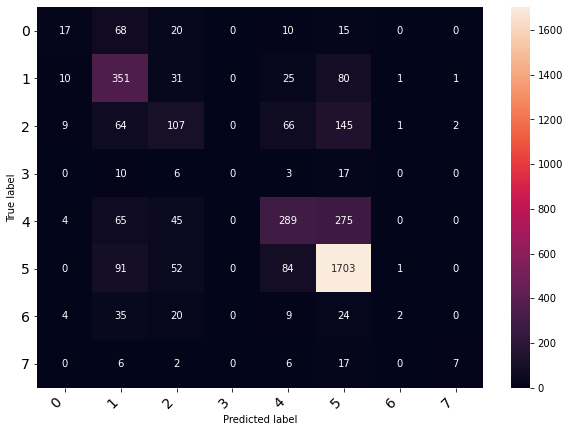

,0,1,2,3,4,5,6,7
0,17,68,20,0,10,15,0,0
1,10,351,31,0,25,80,1,1
2,9,64,107,0,66,145,1,2
3,0,10,6,0,3,17,0,0
4,4,65,45,0,289,275,0,0
5,0,91,52,0,84,1703,1,0
6,4,35,20,0,9,24,2,0
7,0,6,2,0,6,17,0,7


In [81]:
print_confusion_matrix(y_true=test_generator.classes,
                       y_pred=y_pred_class,
                       class_names=range(8))